In [78]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from labdata.schema import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams.update({'font.size': 18})

KILOSORT_PARAMS_SET = 5
METRICS_PARAMS_SET = 1

In [79]:
#UnitMetrics().populate(processes=120, display_progress=True)
#UnitCount().populate(processes=10,display_progress=True)

In [80]:
# Get all the implantation and explantation data from the database
procedures = EphysRecording.ProbeSetting() * Procedure() & 'procedure_type LIKE "chronic%"'
#procedures = procedures & 'subject_name IN ("MM010", "MM009","MM011")'
procedures = pd.DataFrame(procedures.fetch('probe_id', 'subject_name', 'procedure_datetime','procedure_type', order_by='procedure_datetime desc', as_dict=True)).drop_duplicates()
procedures = procedures[::]
#print(f'There are {(len(procedures.probe_id.unique()))} probes in the database')
first_implant = procedures.procedure_datetime.min()
procedures.head()

,subject_name,procedure_type,procedure_datetime,probe_id
0,JC142,chronic explant,2024-03-12 14:00:00,22420007912
1,JC142,chronic explant,2024-03-12 14:00:00,22420007982
44,MM018,chronic implant,2024-02-15 13:00:00,20097916222
45,MM018,chronic implant,2024-02-15 13:00:00,20097916182
46,MM018,chronic implant,2024-02-15 13:00:00,19454421152


In [81]:
# sort probe ids by their first implant
implants = procedures[procedures.procedure_type == 'chronic implant']
first_implants = implants.groupby('probe_id')['procedure_datetime'].min().reset_index()
sorted_prbs = first_implants.sort_values('procedure_datetime', ascending=False).probe_id.values

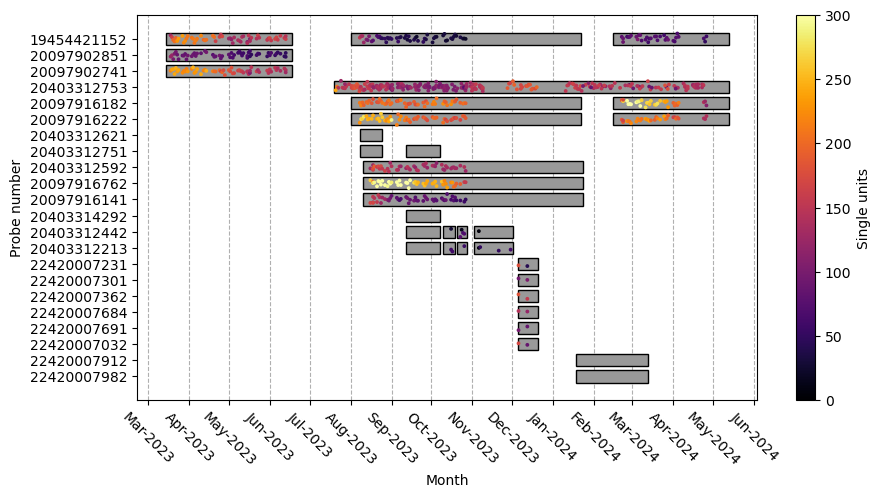

In [82]:
# Plot a Gantt chart for all probes used
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import  matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

fig, ax = plt.subplots(figsize=(10,5))
clims=(0,300)
bar_height = .9
bar_distance = 1.2
#color = list(cm.rainbow(np.linspace(0, 1, len(procedures.probe_id.unique()))))
#color = list(cm.tab20(np.linspace(0, 1, len(procedures.probe_id.unique()))))
prbs, heights = [], []
for prb_ind,prb in enumerate(sorted_prbs):
    implant_times = procedures[(procedures.probe_id == prb) & (procedures.procedure_type == 'chronic implant')].procedure_datetime.values
    explant_times = procedures[(procedures.probe_id == prb) & (procedures.procedure_type == 'chronic explant')].procedure_datetime.values
    height = prb_ind*bar_distance
    for implant in implant_times:
        valid_explants = explant_times[explant_times > implant]
        if len(valid_explants) == 0:
            explant = np.datetime64(datetime.now())
        else:
            explant = valid_explants[np.argmin(valid_explants - implant)]
        #explant = explant[0] if len(explant) else np.datetime64(datetime.now())
        plt.barh([height], np.array(explant-implant), left=[implant], height=bar_height, color='#999999', edgecolor='black',alpha=1)
    prbs.append(prb)
    heights.append(height)

    #get number of single units for a probe
    units_query = Session() * UnitCount() * EphysRecording.ProbeSetting() & dict(probe_id=prb,
                                                                                 unit_criteria_id=METRICS_PARAMS_SET,
                                                                                 parameter_set_num=KILOSORT_PARAMS_SET)
                                                                                 
    recording_dates, num_single_units = units_query.fetch('session_datetime','sua')
    offset = np.random.normal(0, 0.15, len(recording_dates))
    offset = np.clip(offset, -bar_height/2, bar_height/2)
    #offset = np.random.uniform(-bar_height/2, bar_height/2, len(recording_dates))
    scat = plt.scatter(recording_dates, offset + prb_ind*bar_distance, s=3, c=np.array(num_single_units), clim=clims, cmap='inferno', alpha=1)

plt.scatter(first_implant - relativedelta(days=1), 4, s=0) # hacky way to get nicer xlims
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.grid(which='major', axis='x', linestyle='--')
ax.set_axisbelow(True)
plt.ylabel('Probe number')
plt.xlabel('Month')
cbar = plt.colorbar(scat)
cbar.set_label('Single units')
plt.yticks(heights, prbs) # apply serial numbers
plt.xticks(rotation=-45)
#plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

In [83]:
implants = EphysRecording.ProbeSetting() * Procedure() & 'procedure_type LIKE "chronic_implant"'
mice = implants.fetch('subject_name', order_by='procedure_datetime') # sort by implant date
mice = pd.unique(mice)[::-1] #pd.unique preserves order unlike np.unique

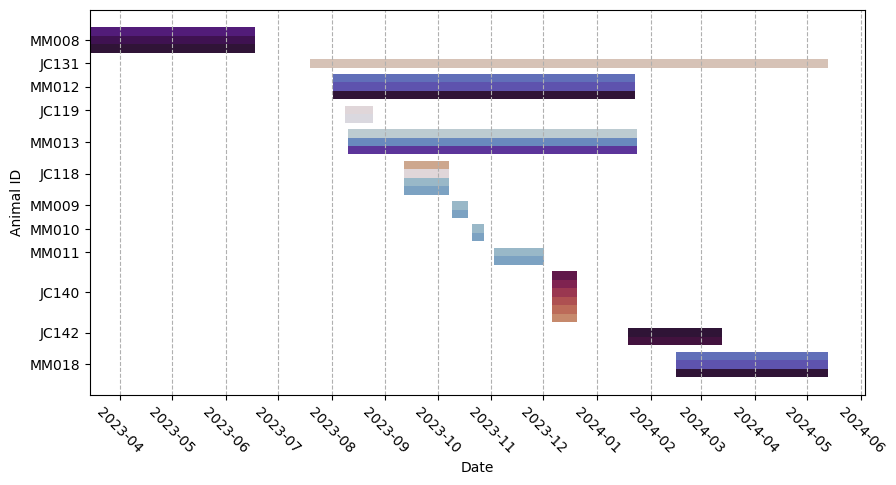

In [84]:
# similar to plot above, but put each mouse on a separate row
procedures = EphysRecording.ProbeSetting() * Procedure() & 'procedure_type LIKE "chronic%"'
probe_ids = np.unique(procedures.fetch('probe_id'))
#colors = np.random.permutation(cm.hsv(np.linspace(0, 1, len(probe_ids))))
#colors = cm.tab20(np.linspace(0, 1, len(probe_ids)))
colors = cm.twilight_shifted(np.linspace(0, 1, len(probe_ids)))
label_locations, prbs, starts, ends, heights, cols = [], [], [], [], [], []

c = 0
for m in mice:
    query = procedures & f'subject_name = "{m}"'
    prbs = np.unique(query.fetch('probe_id'))
    label_locations.append(c + len(prbs) // 2)
    for p in prbs:
        implant_date = (query & f'probe_id = "{p}"' & 'procedure_type = "chronic implant"').fetch('procedure_datetime')[0]
        explant_dates = (query & f'probe_id = "{p}"' & 'procedure_type = "chronic explant"').fetch('procedure_datetime')
        explant_date = explant_dates[0] if len(explant_dates) else datetime.now()
        starts.append(implant_date)
        ends.append(explant_date)
        heights.append(c)
        colind = np.where(probe_ids == p)[0][0]
        cols.append(colors[colind % len(colors)])
        c += 1 
    c +=.75

widths = np.array(ends) - np.array(starts)

fig, ax = plt.subplots(figsize=(10,5))
plt.barh(heights, widths, left=starts, height=1, color=cols)
plt.ylabel('Animal ID')
plt.xlabel('Date')
plt.yticks(label_locations, mice) # apply serial numbers
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid(which='major', axis='x', linestyle='--')
plt.xticks(rotation=-45)
plt.show()

In [85]:
#TODO: add extractions to db and plot probe extraction success 
ProbeExtraction()

subject_name unique mouse id,procedure_type Defines procedures that are not an experimental session,procedure_datetime,probe_id probe id to keep track or re-uses,extraction_successful boolean for successfull or not
JC118,chronic explant,2023-10-07 16:00:00,20403312213,1
JC118,chronic explant,2023-10-07 16:00:00,20403312442,1
JC118,chronic explant,2023-10-07 16:00:00,20403312751,1
JC118,chronic explant,2023-10-07 16:00:00,20403314292,1
JC119,chronic explant,2023-08-24 17:00:00,20403312621,0
JC119,chronic explant,2023-08-24 17:00:00,20403312751,1
JC142,chronic explant,2024-03-12 14:00:00,22420007912,1
JC142,chronic explant,2024-03-12 14:00:00,22420007982,1
MM009,chronic explant,2023-10-18 14:00:00,20403312213,1
MM009,chronic explant,2023-10-18 14:00:00,20403312442,1
